<a href="https://colab.research.google.com/github/Squirtle007/CUDA_Quantum/blob/main/colab/cudaq_tutorial_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Set up CUDA Quantum Environment**

In [15]:
#The following commands are used to set up the environment in Colab
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-keyring_1.0-1_all.deb
!dpkg -i cuda-keyring_1.0-1_all.deb
!apt-get update
!apt-get -y install libcublas-11-8 libcusolver-11-8 cuda-cudart-11-8

%pip install cuda-quantum==0.6.0

--2024-04-09 10:25:16--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-keyring_1.0-1_all.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.199.20.126
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.199.20.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4332 (4.2K) [application/x-deb]
Saving to: ‘cuda-keyring_1.0-1_all.deb.1’

cuda-keyring_1.0-1_ 100%[===================>]   4.23K  --.-KB/s    in 0s      

2024-04-09 10:25:16 (294 MB/s) - ‘cuda-keyring_1.0-1_all.deb.1’ saved [4332/4332]

(Reading database ... 121789 files and directories currently installed.)
Preparing to unpack cuda-keyring_1.0-1_all.deb ...
Unpacking cuda-keyring (1.0-1) over (1.0-1) ...
Setting up cuda-keyring (1.0-1) ...

A deprecated public CUDA GPG key appear to be installed.
To remove the key, run this command:
sudo apt-key del 7fa2af80

Hit:1 http://security.ubuntu.com/ubuntu jammy-sec

# Hybrid Quantum Neural Networks

In this tutorial, we'll learn how to build a hybrid quantum neural netowrk model with pytorch and CUDA-Quantum. This is a simple example but demostrates what CUDA-Quantum is capable of as a hybrid programing model. We will create a hybrid neural network with one layer being a quantum circuit and apply it to a classification problem with MNIST data set.

# Setup

As first step, we load the necessary python modules, including torch and cudaq. We will be using pytorch for the classical part and CUDA-Quantum for the quantum circuit.

In [16]:
!pip install torch==2.2.1
!pip install torch torchvision==0.17.1

In [17]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import cudaq
from cudaq import spin

# Quantum Circuit

We build a quantum circuit with n_qubits parameterized quantum kernel. A Hadarmad opertor and a rotational operator are applied on all qubits. The result returned is the expectation value. This quantum circuit can be used as a alternative to the softmax layer in classification problem. This will provides us a simple interface for interaction with the quantum circuit later in the classical part.

In [18]:
class QuantumCircuit:
    """
    This class provides a simple interface for interaction
    with the quantum circuit
    """

    def __init__(self, n_qubits):

        kernel, theta = cudaq.make_kernel(list)

        self.kernel = kernel

        self.theta = theta

        qubits = kernel.qalloc(n_qubits)

        self.kernel.h(qubits)

        kernel.ry(theta[0], qubits)


    def run(self, thetas):

        expectation = cudaq.observe(self.kernel, spin.z(0), thetas).expectation()

        return np.array([expectation])

We can simulate this quantum circuit with cuquantum backend.

In [19]:
simulator = cudaq.set_target('nvidia')

circuit = QuantumCircuit(1)
circuit.run([6])

array([0.27941549])

# Hybrid function and Hybrid Module with Pytorch

Now we create the hybrid function based on torch.Function class and hybrid module based on torch.nn.Module. In HybridFunction, we define the forward pass and the backward pass which is essential for training. The gradient is computed with parameter shift. The hybrid module is composed by the quantum circuit and the hybrid function.

In [20]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """

    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation])
        ctx.save_for_backward(input, result)

        return result

    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation = ctx.saved_tensors
        input_list = np.array(input.tolist())

        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift

        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])

            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """

    def __init__(self, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1)
        self.shift = shift

    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

# MNIST data

We download the MNIST dataset as training data. For more information on MNIST dataset, please refer to http://yann.lecun.com/exdb/mnist/.

For demostration purpose, we only took the digits 0 and 1 with 100 samples each for training.

In [21]:
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples],
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

Here we display the digits and labels of the dataset

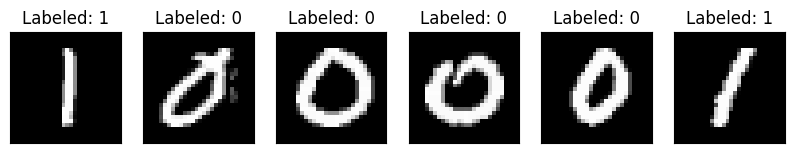

In [22]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))

    n_samples_show -= 1

Similarly we create a test dataset from MNIST with digit 0 and 1 each with 50 samples

In [23]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples],
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

# Neural Network Model

Now we create our hybrid quantum neural network model with pytorch. WQe create this particular network with two convolutional layers, followed by a fully connected layer and a hybrid quantum circuit layer.

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = Hybrid(np.pi / 2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

# Training

We create the training loop with negative log likelihood loss.

In [25]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()

        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

Training [5%]	Loss: -1.1139
Training [10%]	Loss: -1.3473
Training [15%]	Loss: -1.3700
Training [20%]	Loss: -1.3913
Training [25%]	Loss: -1.4023
Training [30%]	Loss: -1.4110
Training [35%]	Loss: -1.4272
Training [40%]	Loss: -1.4236
Training [45%]	Loss: -1.4311
Training [50%]	Loss: -1.4551
Training [55%]	Loss: -1.4614
Training [60%]	Loss: -1.4496
Training [65%]	Loss: -1.4618
Training [70%]	Loss: -1.4666
Training [75%]	Loss: -1.4746
Training [80%]	Loss: -1.4735
Training [85%]	Loss: -1.4829
Training [90%]	Loss: -1.4755
Training [95%]	Loss: -1.4826
Training [100%]	Loss: -1.4847


Text(0, 0.5, 'Neg Log Likelihood Loss')

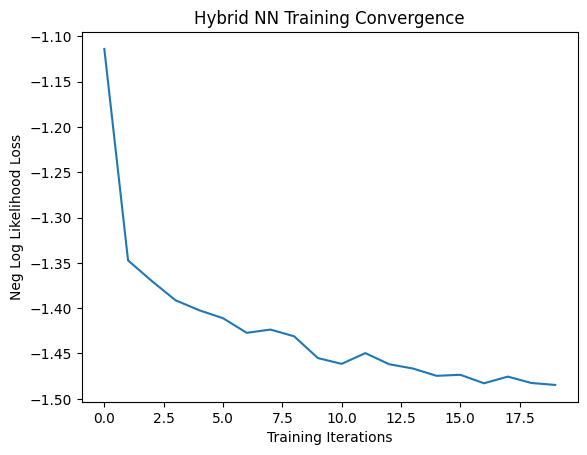

In [26]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

# Test

Now we test the trained model with the test dataset by output its loss and accuracy.

In [27]:
model.eval()
with torch.no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -1.4524
	Accuracy: 100.0%


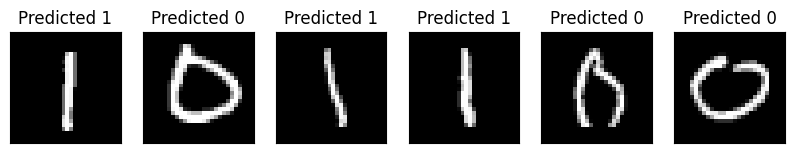

In [28]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))

        count += 1